# Loan Prediction Notebook

Loading of libraries

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# data visualization
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib import style

# Algorithms
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import GaussianNB
import re
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import log_loss
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import LeavePOut
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import StratifiedKFold
#Parameter Tuning
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

Loading and Summarizing Data

In [2]:
data = pd.read_csv("data.csv")
data.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [25]:
# let's see how our response variable is distributed 
data['Loan_Status'].value_counts()

1    422
0    192
Name: Loan_Status, dtype: int64

In [4]:
#Crosstabs sample #pd.crosstab(df.make, df.num_doors, margins=True, margins_name="Total")
#Grouping #pd.crosstab(df.make, [df.body_style, df.drive_wheels])
#Visualize
#sns.heatmap(pd.crosstab([df.make, df.num_doors], [df.body_style, df.drive_wheels]),cmap="YlGnBu", annot=True, cbar=False)
pd.crosstab(data.LoanAmount, data.Loan_Status)

Loan_Status,N,Y
LoanAmount,,
9.0,1,0
17.0,0,1
25.0,0,2
26.0,0,1
30.0,0,2
...,...,...
500.0,1,0
570.0,1,0
600.0,0,2


In [5]:
print(data.shape)
data.describe().transpose()

(614, 13)


,count,mean,std,min,25%,50%,75%,max
ApplicantIncome,614.0,5403.459283,6109.041673,150.0,2877.5,3812.5,5795.00,81000.0
CoapplicantIncome,614.0,1621.245798,2926.248369,0.0,0.0,1188.5,2297.25,41667.0
LoanAmount,592.0,146.412162,85.587325,9.0,100.0,128.0,168.00,700.0
Loan_Amount_Term,600.0,342.000000,65.120410,12.0,360.0,360.0,360.00,480.0
Credit_History,564.0,0.842199,0.364878,0.0,1.0,1.0,1.00,1.0


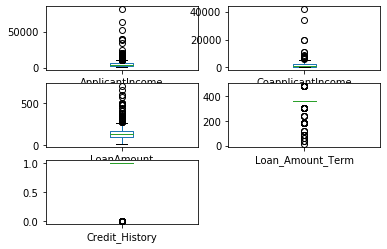

In [6]:
# box and whisker plots
data.plot(kind='box', subplots=True, layout=(3,2), sharex=False, sharey=False)
plt.show()

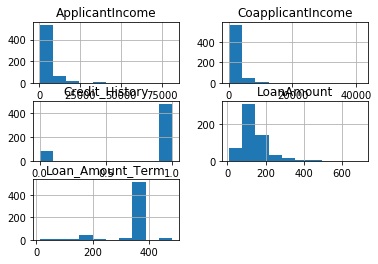

In [7]:
# histograms
data.hist()
plt.show()

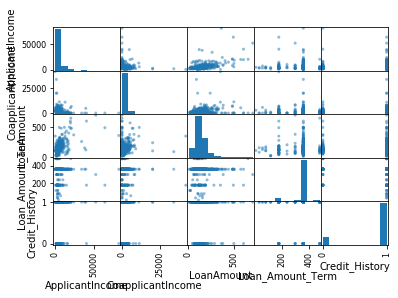

In [8]:
# scatter plot matrix
pd.plotting.scatter_matrix(data)
plt.show()

Exploration, Feature Engineering And Data Cleaning

In [9]:
#Lets Look At Missing Data
total = data.isnull().sum().sort_values(ascending=False)
percent_1 = data.isnull().sum()/data.isnull().count()*100
percent_2 = (round(percent_1, 1)).sort_values(ascending=False)
missing_data = pd.concat([total, percent_2], axis=1, keys=['Total Missing', '%'])
missing_data.head(13)

,Total Missing,%
Credit_History,50,8.1
Self_Employed,32,5.2
LoanAmount,22,3.6
Dependents,15,2.4
Loan_Amount_Term,14,2.3
Gender,13,2.1
Married,3,0.5
Loan_Status,0,0.0
Property_Area,0,0.0
CoapplicantIncome,0,0.0


In [10]:
def encode_labels(df, cols = None):
    '''
    Inputs:
        df: a pandas dataframe containing the column for which to calculate target encoding (categ_col)
        cols: all columns' names for which to do label encoding . If is None (default) then all object columns are taken.
    Output: df with cols replaced the coresponding label encodings while maintaining all existing None values at their positions.
    '''

    le = LabelEncoder()
    for col in cols:
        # pick some random value from the col - will make it null back at the end anyway
        null_replacement = df[col].values[0]
        # save col null positions and set ones for the rest
        nan_col = np.array([1 if not pd.isnull(x) else x for x in df[col]])
        # replace nulls in the original array, and fit on it
        a = np.array([x if not pd.isnull(x) else null_replacement for x in df[col]])
        le.fit(a)
        # transform the data and add the nulls back
        df[col] = le.transform(a) * nan_col

    return(df) 

In [11]:
#Convert Categorical features into numerics.
data = encode_labels(data, cols = ['Gender','Married','Dependents','Education','Self_Employed','Property_Area','Loan_Status'])
data.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,1.0,0.0,0.0,0,0.0,5849,0.0,NaN,360.0,1.0,2,1
1,LP001003,1.0,1.0,1.0,0,0.0,4583,1508.0,128.0,360.0,1.0,0,0
2,LP001005,1.0,1.0,0.0,0,1.0,3000,0.0,66.0,360.0,1.0,2,1
3,LP001006,1.0,1.0,0.0,1,0.0,2583,2358.0,120.0,360.0,1.0,2,1
4,LP001008,1.0,0.0,0.0,0,0.0,6000,0.0,141.0,360.0,1.0,2,1


In [12]:
#Clean both train and test set

#Train Data
data['LoanAmount'].fillna(data['LoanAmount'].mean(),inplace=True)
data['Credit_History'].fillna(data['Credit_History'].mode()[0],inplace=True)
#Fill 'No' to Self Employed
data['Self_Employed'].fillna(0,inplace=True)
data['Dependents'].fillna(data['Dependents'].mode()[0],inplace=True)
data['Loan_Amount_Term'].fillna(data['Loan_Amount_Term'].mode()[0],inplace=True)
data['Gender'].fillna(data['Gender'].mode()[0],inplace=True)
data['Married'].fillna(data['Married'].mode()[0],inplace=True)
    
data.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,1.0,0.0,0.0,0,0.0,5849,0.0,146.412162,360.0,1.0,2,1
1,LP001003,1.0,1.0,1.0,0,0.0,4583,1508.0,128.000000,360.0,1.0,0,0
2,LP001005,1.0,1.0,0.0,0,1.0,3000,0.0,66.000000,360.0,1.0,2,1
3,LP001006,1.0,1.0,0.0,1,0.0,2583,2358.0,120.000000,360.0,1.0,2,1
4,LP001008,1.0,0.0,0.0,0,0.0,6000,0.0,141.000000,360.0,1.0,2,1


In [13]:
#Convert Gender from string to integers
data['Gender'] = data['Gender'].astype('int64')
data['Married'] = data['Married'].astype('int64')
data['Dependents'] = data['Dependents'].astype('int64')
data['Credit_History'] = data['Credit_History'].astype('int64')
data['Loan_Amount_Term'] = data['Loan_Amount_Term'].astype('int64')
data['Self_Employed'] = data['Self_Employed'].astype('int64')

print(data.dtypes)
data.head()

Loan_ID               object
Gender                 int64
Married                int64
Dependents             int64
Education              int64
Self_Employed          int64
ApplicantIncome        int64
CoapplicantIncome    float64
LoanAmount           float64
Loan_Amount_Term       int64
Credit_History         int64
Property_Area          int64
Loan_Status            int64
dtype: object


,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,1,0,0,0,0,5849,0.0,146.412162,360,1,2,1
1,LP001003,1,1,1,0,0,4583,1508.0,128.000000,360,1,0,0
2,LP001005,1,1,0,0,1,3000,0.0,66.000000,360,1,2,1
3,LP001006,1,1,0,1,0,2583,2358.0,120.000000,360,1,2,1
4,LP001008,1,0,0,0,0,6000,0.0,141.000000,360,1,2,1


Drop The Loan_ID from the train set, because it does not contribute to whether loan is repaid or not

In [14]:
data = data.drop(['Loan_ID'], axis=1)  

Distribution

In [15]:
data['ApplicantIncome'].describe()

count      614.000000
mean      5403.459283
std       6109.041673
min        150.000000
25%       2877.500000
50%       3812.500000
75%       5795.000000
max      81000.000000
Name: ApplicantIncome, dtype: float64

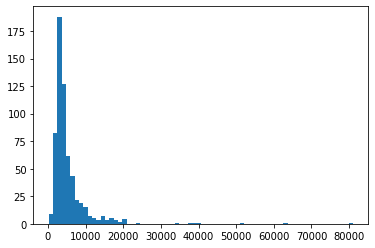

In [16]:
data['ApplicantIncome'].hist(bins=70,grid=False)

# ========== Building The Models ===========

In [17]:
#Creating Training and Test Sets
Y = data["Loan_Status"].values
X = data.drop("Loan_Status", axis=1).values

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.20, random_state=100)

# Cross-Validation

In [37]:
#Classification algos cross validation
def classification_cross_validation(algorithm_dict, kfold_splits, stratified_kfold_splits, random_state, test_size, X, Y):

    result_dfs = []
    for name, model in algorithm_dict.items():
        #K-fold Cross-Validation
        kfold = KFold(n_splits=kfold_splits, random_state=random_state)
        results_kfold = cross_val_score(model, X, Y, cv=kfold)
        results_kfold_av_accuracy = "Accuracy: %.2f%% (std %.2f%%)" % (results_kfold.mean()*100.0, results_kfold.std()*100.0)
        #Stratified K-fold Cross-Validation
        skfold = StratifiedKFold(n_splits=stratified_kfold_splits, random_state=random_state)
        results_skfold = cross_val_score(model, X, Y, cv=skfold)
        results_skfold_av_accuracy = "Accuracy: %.2f%% (std %.2f%%)" % (results_skfold.mean()*100.0, results_skfold.std()*100.0)
        #Leave One Out Cross-Validation (LOOCV)
        #loocv = LeaveOneOut()
        #results_loocv = cross_val_score(model, X, Y, cv=loocv)
        #results_loocv_av_accuracy = "Accuracy: %.2f%% (std %.2f%%)" % (results_loocv.mean()*100.0, results_loocv.std()*100.0)
        #Repeated Random Test-Train Splits
        kfold2 = ShuffleSplit(n_splits=kfold_splits, test_size=test_size, random_state=random_state)
        results_4 = cross_val_score(model, X, Y, cv=kfold2)
        results_4_av_accuracy = "Accuracy: %.2f%% (std %.2f%%)" % (results_4.mean()*100.0, results_4.std()*100.0)
 
        data = {'Algorithm Name':  [name, '', ''],
            'Cross-Validation Name': ['K-fold', 'Stratified K-fold','Repeated Random Test-Train Splits'],
            'Accuracy': [results_kfold_av_accuracy, results_skfold_av_accuracy,results_4_av_accuracy]}
        df = pd.DataFrame (data, columns = ['Algorithm Name','Cross-Validation Name','Accuracy'])
        result_dfs.append(df)
    return pd.concat(result_dfs)

# Fitting Several Models to select the best later

In [38]:
models = {}
models['Logistic Regression'] = LogisticRegression(solver='liblinear', max_iter=100)
models['K-Neighbors Classifier'] = KNeighborsClassifier(n_neighbors = 3)
models['Random Forest Classifier'] = RandomForestClassifier(n_estimators=100)
models['Decision Tree Classifier'] = DecisionTreeClassifier()
models['SGD Classifier'] = linear_model.SGDClassifier(max_iter=5, tol=None)
models['Gaussian Naive Bayes'] = GaussianNB()
models['Perceptron'] = Perceptron(max_iter=100)
models['Linear Support Vector Machine'] = SVC(kernel='linear')

classification_cross_validation(models, 10, 3, None, 0.30, X_train, Y_train).head(50)

,Algorithm Name,Cross-Validation Name,Accuracy
0,Logistic Regression,K-fold,Accuracy: 82.29% (std 5.05%)
1,,Stratified K-fold,Accuracy: 82.08% (std 0.75%)
2,,Repeated Random Test-Train Splits,Accuracy: 81.96% (std 3.32%)
0,K-Neighbors Classifier,K-fold,Accuracy: 62.32% (std 7.02%)
1,,Stratified K-fold,Accuracy: 62.53% (std 1.25%)
2,,Repeated Random Test-Train Splits,Accuracy: 62.91% (std 1.77%)
0,Random Forest Classifier,K-fold,Accuracy: 80.86% (std 4.99%)
1,,Stratified K-fold,Accuracy: 80.85% (std 2.33%)
2,,Repeated Random Test-Train Splits,Accuracy: 81.49% (std 2.44%)
0,Decision Tree Classifier,K-fold,Accuracy: 71.28% (std 5.04%)


In [18]:
#Classification KFold algorithm cross validation
def classification_kfold_cross_validation(algorithm_dict, kfold_splits, random_state, X, Y):
    result_dfs = []
    for name, model in algorithm_dict.items():
        kfold = KFold(n_splits=kfold_splits, random_state=random_state)
        results_kfold = cross_val_score(model, X, Y, cv=kfold)
        results_kfold_av_accuracy = "Accuracy: %.2f%% (std %.2f%%)" % (results_kfold.mean()*100.0, results_kfold.std()*100.0)

        data = {'Algorithm Name':  [name],
        'Accuracy': [results_kfold_av_accuracy]}
        df = pd.DataFrame (data, columns = ['Algorithm Name','Accuracy'])
        result_dfs.append(df)

    result_df = (pd.concat(result_dfs)).sort_values(by='Accuracy', ascending=False)
    result_df = result_df.set_index('Algorithm Name')
    return result_df

In [19]:
#Classification KFold algorithm cross validation
models = {}
models['Logistic Regression'] = LogisticRegression(solver='liblinear', max_iter=100)
models['K-Neighbors Classifier'] = KNeighborsClassifier(n_neighbors = 3)
models['Random Forest Classifier'] = RandomForestClassifier(n_estimators=100)
models['Decision Tree Classifier'] = DecisionTreeClassifier()
models['SGD Classifier'] = linear_model.SGDClassifier(max_iter=5, tol=None)
models['Gaussian Naive Bayes'] = GaussianNB()
models['Perceptron'] = Perceptron(max_iter=100)
models['Linear Support Vector Machine'] = SVC(kernel='linear')

classification_kfold_cross_validation(models, 10, None, X_train, Y_train).head(50)

,Algorithm Name,Accuracy
0,Logistic Regression,Accuracy: 82.29% (std 5.05%)
0,K-Neighbors Classifier,Accuracy: 62.32% (std 7.02%)
0,Random Forest Classifier,Accuracy: 80.45% (std 4.73%)
0,Decision Tree Classifier,Accuracy: 70.47% (std 5.58%)
0,SGD Classifier,Accuracy: 58.25% (std 18.94%)
0,Gaussian Naive Bayes,Accuracy: 80.05% (std 5.84%)
0,Perceptron,Accuracy: 60.06% (std 17.09%)
0,Linear Support Vector Machine,Accuracy: 80.05% (std 6.05%)


We need to select one model, that performed better. And from above, Logistic Regression appears to be performing better than others listed. But now we need to fit all the models on new (unseen) data. We will now evaluate each model on test data 

In [22]:
#Stochastic Gradient Descent (SGD):

sgd = linear_model.SGDClassifier(max_iter=5, tol=None)
sgd.fit(X_train, Y_train)
Y_pred = sgd.predict(X_test)
#acc_sgd = round(sgd.score(X_train, Y_train) * 100, 2)
#accuracy_score works well only if there are equal number of samples belonging to each class
acc_sgd = round(accuracy_score(Y_test, Y_pred) * 100, 2)
#Area Under Curve is used for binary classification problems like ours
#AUC has a range of [0, 1]. The greater the value, the better is the performance of our model
roc_sgd = round(roc_auc_score(Y_test, Y_pred), 2)
#Log loss is best for multiclass classification and is from 0-infinity. Closer to zero mean higher accuracy
logloss_sgd = round(log_loss(Y_test, Y_pred), 2)

print ('Confusion Matrix :')
print(confusion_matrix(Y_test, Y_pred))

#Precision – What percent of your predictions were correct?
#Recall – What percent of the positive cases did you catch? 
#F1 score – What percent of positive predictions were correct? 
print ('Classification Report : ')
print (classification_report(Y_test, Y_pred))

Confusion Matrix :
[[ 2 46]
 [ 4 71]]
Classification Report : 
              precision    recall  f1-score   support

           0       0.33      0.04      0.07        48
           1       0.61      0.95      0.74        75

    accuracy                           0.59       123
   macro avg       0.47      0.49      0.41       123
weighted avg       0.50      0.59      0.48       123



In [23]:
#Random Forest:

random_forest = RandomForestClassifier(n_estimators=100)
random_forest.fit(X_train, Y_train)
Y_prediction = random_forest.predict(X_test)
#acc_random_forest = round(random_forest.score(X_train, Y_train) * 100, 2)
acc_random_forest = round(accuracy_score(Y_test, Y_prediction) * 100, 2)
roc_random_forest = round(roc_auc_score(Y_test, Y_prediction), 2)
logloss_random_forest = round(log_loss(Y_test, Y_prediction), 2)

print ('Confusion Matrix :')
print(confusion_matrix(Y_test, Y_prediction))

print ('Classification Report : ')
print (classification_report(Y_test, Y_prediction))

Confusion Matrix :
[[20 28]
 [ 6 69]]
Classification Report : 
              precision    recall  f1-score   support

           0       0.77      0.42      0.54        48
           1       0.71      0.92      0.80        75

    accuracy                           0.72       123
   macro avg       0.74      0.67      0.67       123
weighted avg       0.73      0.72      0.70       123



In [24]:
#Logistic Regression:
logreg = LogisticRegression(solver='liblinear', max_iter=100)
logreg.fit(X_train, Y_train)
Y_pred = logreg.predict(X_test)
#acc_log = round(logreg.score(X_train, Y_train) * 100, 2)
acc_log = round(accuracy_score(Y_test, Y_pred) * 100, 2)
roc_log = round(roc_auc_score(Y_test, Y_pred), 2)
logloss_log = round(log_loss(Y_test, Y_pred), 2)

print ('Confusion Matrix :')
print(confusion_matrix(Y_test, Y_pred))

print ('Classification Report : ')
print (classification_report(Y_test, Y_pred))

Confusion Matrix :
[[18 30]
 [ 3 72]]
Classification Report : 
              precision    recall  f1-score   support

           0       0.86      0.38      0.52        48
           1       0.71      0.96      0.81        75

    accuracy                           0.73       123
   macro avg       0.78      0.67      0.67       123
weighted avg       0.76      0.73      0.70       123



In [25]:
#K Nearest Neighbor:
knn = KNeighborsClassifier(n_neighbors = 3) 
knn.fit(X_train, Y_train)  
Y_pred = knn.predict(X_test)  
#acc_knn = round(knn.score(X_train, Y_train) * 100, 2)
acc_knn = round(accuracy_score(Y_test, Y_pred) * 100, 2)
roc_knn = round(roc_auc_score(Y_test, Y_pred), 2)
logloss_knn = round(log_loss(Y_test, Y_pred), 2)

print ('Confusion Matrix :')
print(confusion_matrix(Y_test, Y_pred))

print ('Classification Report : ')
print (classification_report(Y_test, Y_pred))

Confusion Matrix :
[[14 34]
 [15 60]]
Classification Report : 
              precision    recall  f1-score   support

           0       0.48      0.29      0.36        48
           1       0.64      0.80      0.71        75

    accuracy                           0.60       123
   macro avg       0.56      0.55      0.54       123
weighted avg       0.58      0.60      0.57       123



In [26]:
#Gaussian Naive Bayes:
gaussian = GaussianNB() 
gaussian.fit(X_train, Y_train)  
Y_pred = gaussian.predict(X_test)  
#acc_gaussian = round(gaussian.score(X_train, Y_train) * 100, 2)
acc_gaussian = round(accuracy_score(Y_test, Y_pred) * 100, 2)
roc_gaussian = round(roc_auc_score(Y_test, Y_pred), 2)
logloss_gaussian = round(log_loss(Y_test, Y_pred), 2)

print ('Confusion Matrix :')
print(confusion_matrix(Y_test, Y_pred))

print ('Classification Report : ')
print (classification_report(Y_test, Y_pred))

Confusion Matrix :
[[21 27]
 [ 6 69]]
Classification Report : 
              precision    recall  f1-score   support

           0       0.78      0.44      0.56        48
           1       0.72      0.92      0.81        75

    accuracy                           0.73       123
   macro avg       0.75      0.68      0.68       123
weighted avg       0.74      0.73      0.71       123



In [27]:
#Perceptron:
perceptron = Perceptron(max_iter=100)
perceptron.fit(X_train, Y_train)
Y_pred = perceptron.predict(X_test)
#acc_perceptron = round(perceptron.score(X_train, Y_train) * 100, 2)
acc_perceptron = round(accuracy_score(Y_test, Y_pred) * 100, 2)
roc_perceptron = round(roc_auc_score(Y_test, Y_pred), 2)
logloss_perceptron = round(log_loss(Y_test, Y_pred), 2)

print ('Confusion Matrix :')
print(confusion_matrix(Y_test, Y_pred))

print ('Classification Report : ')
print (classification_report(Y_test, Y_pred))

Confusion Matrix :
[[ 0 48]
 [ 0 75]]
Classification Report : 
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        48
           1       0.61      1.00      0.76        75

    accuracy                           0.61       123
   macro avg       0.30      0.50      0.38       123
weighted avg       0.37      0.61      0.46       123



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [28]:
#Decision Tree
decision_tree = DecisionTreeClassifier() 
decision_tree.fit(X_train, Y_train)  
Y_pred = decision_tree.predict(X_test)  
#acc_decision_tree = round(decision_tree.score(X_train, Y_train) * 100, 2)
acc_decision_tree = round(accuracy_score(Y_test, Y_pred) * 100, 2)
roc_decision_tree = round(roc_auc_score(Y_test, Y_pred), 2)
logloss_decision_tree = round(log_loss(Y_test, Y_pred), 2)

print ('Confusion Matrix :')
print(confusion_matrix(Y_test, Y_pred))

print ('Classification Report : ')
print (classification_report(Y_test, Y_pred))

Confusion Matrix :
[[30 18]
 [18 57]]
Classification Report : 
              precision    recall  f1-score   support

           0       0.62      0.62      0.62        48
           1       0.76      0.76      0.76        75

    accuracy                           0.71       123
   macro avg       0.69      0.69      0.69       123
weighted avg       0.71      0.71      0.71       123



In [29]:
#Linear Support Vector Machine:
linear_svc = SVC(kernel='linear')
linear_svc.fit(X_train, Y_train)
Y_pred = linear_svc.predict(X_test)
#acc_linear_svc = round(linear_svc.score(X_train, Y_train) * 100, 2)
acc_linear_svc = round(accuracy_score(Y_test, Y_pred) * 100, 2)
roc_linear_svc = round(roc_auc_score(Y_test, Y_pred), 2)
logloss_linear_svc = round(log_loss(Y_test, Y_pred), 2)

print ('Confusion Matrix :')
print(confusion_matrix(Y_test, Y_pred))

print ('Classification Report : ')
print (classification_report(Y_test, Y_pred))

Confusion Matrix :
[[19 29]
 [ 2 73]]
Classification Report : 
              precision    recall  f1-score   support

           0       0.90      0.40      0.55        48
           1       0.72      0.97      0.82        75

    accuracy                           0.75       123
   macro avg       0.81      0.68      0.69       123
weighted avg       0.79      0.75      0.72       123



================== Which is the best Model ? =================

In [30]:
results = pd.DataFrame({'Model': ['Support Vector Machines', 'KNN', 'Logistic Regression', 
              'Random Forest', 'Naive Bayes', 'Perceptron', 
              'Stochastic Gradient Decent', 
              'Decision Tree'],
    'Accuracy': [acc_linear_svc, acc_knn, acc_log, 
              acc_random_forest, acc_gaussian, acc_perceptron, 
              acc_sgd, acc_decision_tree],
                       'ROC': [roc_linear_svc, roc_knn, roc_log, 
              roc_random_forest, roc_gaussian, roc_perceptron, 
              roc_sgd, roc_decision_tree],
                       'LogLoss': [logloss_linear_svc, logloss_knn, logloss_log, 
              logloss_random_forest, logloss_gaussian, logloss_perceptron, 
              logloss_sgd, logloss_decision_tree]})
result_df = results.sort_values(by='Accuracy', ascending=False)
result_df = result_df.set_index('Model')
result_df.head(9)

,Accuracy,ROC,LogLoss
Model,,,
Support Vector Machines,74.80,0.68,8.71
Logistic Regression,73.17,0.67,9.27
Naive Bayes,73.17,0.68,9.27
Random Forest,72.36,0.67,9.55
Decision Tree,70.73,0.69,10.11
Perceptron,60.98,0.50,13.48
KNN,60.16,0.55,13.76
Stochastic Gradient Decent,59.35,0.49,14.04


# As we can see, the SVM classifier goes on the first place. But first, let us try to tune the model parameters and see if we can improve its accuracy. We will use  GridsearchCV

# Use GridsearchCV:

In [20]:
#defining parameter range 
parameters = [{'C': [1,10,100], 'kernel': ['linear']}]
grid = GridSearchCV(estimator= SVC(), param_grid = parameters, scoring = 'accuracy',cv = 5)

#fitting the model for grid search 
grid.fit(X_train, Y_train) 


#print best parameter after tuning 
print(grid.best_params_) 
  
#print how our model looks after hyper-parameter tuning 
print(grid.best_estimator_) 


grid_predictions = grid.predict(X_test)

accuracy = grid.best_score_ *100
print("==============================Accuracy score==============================")
print(accuracy)

#print classification report 
print(classification_report(Y_test, grid_predictions)) 

{'C': 10, 'kernel': 'linear'}
SVC(C=10, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)
==============================Accuracy score==============================
80.24531024531025
              precision    recall  f1-score   support

           0       0.89      0.33      0.48        48
           1       0.70      0.97      0.81        75

    accuracy                           0.72       123
   macro avg       0.79      0.65      0.65       123
weighted avg       0.77      0.72      0.68       123



Our model has improved to an average accuracy of 80%. But we will use the classification report accuracy of 0.72 as shown below with the Confusion Matrix

# Confusion Matrix

In [23]:
print ('Confusion Matrix :')
print(confusion_matrix(Y_test, grid_predictions))

Confusion Matrix :
[[16 32]
 [ 2 73]]
